29.499312082854942
32.011359715704145
34.62053528686823
37.32686835831697
40.1353657149603
43.0450442875283
46.05491793550749
49.17262147181674
52.393773967178106
55.72924034356771
59.173794613219684
62.7329356001631
66.40448175013444
70.18774707148276
74.08833118706156
78.10262043103131
82.23821433256819
86.49052250733632
90.85861814590203
95.3402785994407
99.92878200330131
104.6345199875172
109.44322831342316
114.36480337714733
119.3823674129739
124.49816861099947
129.7075609456449
135.00520135983555
140.39862924140226
145.874931021316
151.43795947308888
157.08615572463702
162.81637630859018
168.64284052028438
174.5576003994595
180.57352689930576
186.69372196043582
192.92543350122918
199.28185672369807
205.7700648739736
212.4005491926929
219.18585128355966
226.13391124627023
233.25104890026006
240.5439543411733
248.01792243884324
255.67314297585477
263.50244977576267
271.4974921962046
279.6434477561852
287.9295513088583
296.33817122581615
304.8500173812926
313.44491796650163
322.1152

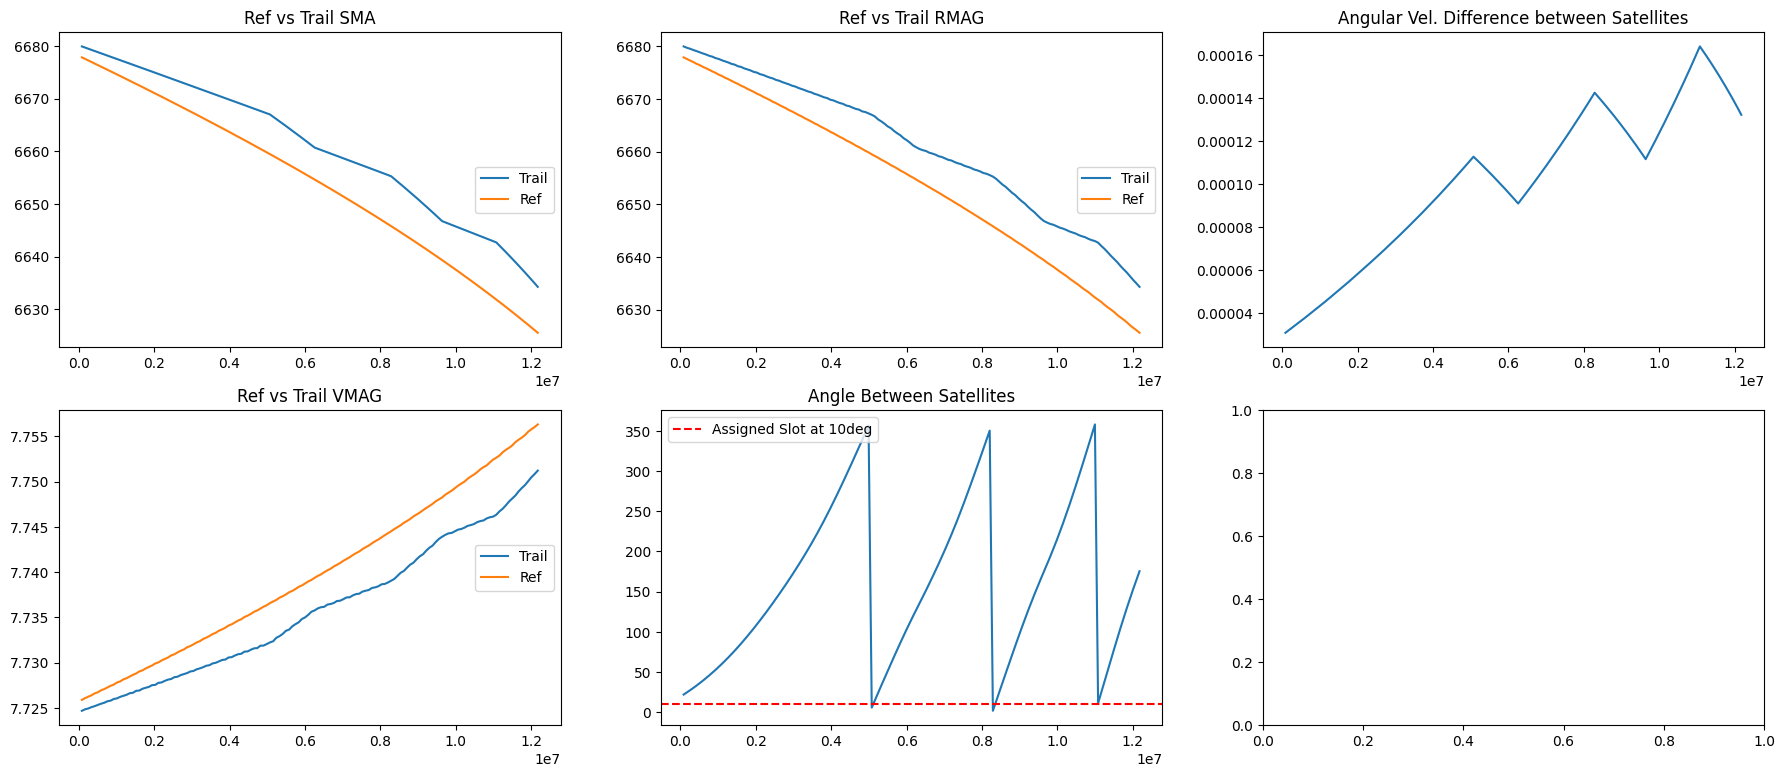

In [10]:
import numpy as np

import cmath

import matplotlib.pyplot as plt

import time

from poliastro.twobody.events import LithobrakeEvent
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.util import norm
from poliastro.constants import R_earth, R_mean_earth, GM_earth
from poliastro.core.elements import coe2rv
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time

from datetime import datetime, timedelta
from sso_inc import inc_from_alt, raan_from_ltan,angle_between
from perturbations import perturbations_atm_J2, pertubations_coesa_high, pertubations_coesa_low, pertubations_coesa_med, acc_max_vs_min, relative_acc 


from scipy.optimize import line_search

toc = time.time()
## Orbit
h = 300
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')

reference_orbit = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc,
    raan,
    argp,
    nu,
    epoch
    )
trailing_orbit = Orbit.from_classical(
    Earth,
    a+(2<<u.km),
    ecc,
    inc,
    raan,
    argp,
    nu+(-20<<u.deg),
    epoch
    )

# Prop
start_date_ts = datetime.timestamp(start_date)
stop_date_ts = datetime.timestamp(start_date + timedelta(hours = 24*7*20))
sample_num = 9*1*16 #*7*2
timestamps = np.linspace(start_date_ts, stop_date_ts, sample_num)
time_step = (timestamps[1]-timestamps[0]) << u.s
refsmalist = []
trailsmalist = []

assignment = 10

ref_vel = []
trail_vel = []

elapsedsecs = []
secs = 0

rmag_ref = []
rmag_trail = []

vmag_ref = []
vmag_trail = []

angle_list = []

# ang_vel_ref_list = []
# ang_vel_trail_list = []
ang_vel_list = []

fig, ax = plt.subplots(2, 3, figsize=(22,9), squeeze=False) 


for timestamp in range(len(timestamps)):
     
    secs += time_step.value
    tra_orb_10days = trailing_orbit.propagate(10<<u.day, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_med))

    a_err = trailing_orbit.a.value - reference_orbit.a.value
    theta_err = angle_between(trailing_orbit.r.value,reference_orbit.r.value) + 10

    print(theta_err)
    a_dot_rel = (trailing_orbit.a.value - tra_orb_10days.a.value) / (10*24*60*60)

    t_theta = theta_err / (reference_orbit.n.to_value(u.deg/u.s) - trailing_orbit.n.to_value(u.deg/u.s))
    t_a = a_err / a_dot_rel
    
    reference_orbit = reference_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_med))

    if t_theta > t_a:
        trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_low))
    elif t_theta < t_a:
        trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_high))  

    elapsedsecs.append(secs)
    refsmalist.append(reference_orbit.a.value)
    trailsmalist.append(trailing_orbit.a.value)

    rmag_ref.append(np.linalg.norm(reference_orbit.r.value))
    rmag_trail.append(np.linalg.norm(trailing_orbit.r.value))  

    vmag_ref.append(np.linalg.norm(reference_orbit.v.value))
    vmag_trail.append(np.linalg.norm(trailing_orbit.v.value))
    
    angle_list.append(angle_between(trailing_orbit.r.value,reference_orbit.r.value))
    
    ang_vel_ref = (360 << u.deg) / reference_orbit.period
    ang_vel_trail = (360 <<u.deg) / trailing_orbit.period
    ang_vel_diff =  ang_vel_ref - ang_vel_trail
    ang_vel_list.append(ang_vel_diff.value)



ax[0,0].plot(elapsedsecs,trailsmalist,label='Trail')
ax[0,0].plot(elapsedsecs,refsmalist,label='Ref')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('Ref vs Trail SMA')

ax[0,1].plot(elapsedsecs,rmag_trail,label='Trail')
ax[0,1].plot(elapsedsecs,rmag_ref,label='Ref')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('Ref vs Trail RMAG')

ax[1,0].plot(elapsedsecs,vmag_trail,label='Trail')
ax[1,0].plot(elapsedsecs,vmag_ref, label='Ref')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('Ref vs Trail VMAG')

# z = np.polyfit(elapsedsecs, angle_list, 1)
# p = np.poly1d(z)

ax[1,1].plot(elapsedsecs,angle_list)
# ax[1,1].plot(elapsedsecs,p(elapsedsecs))
ax[1,1].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('Angle Between Satellites')

ax[0,2].plot(elapsedsecs,ang_vel_list)
ax[0,2].set_title('Angular Vel. Difference between Satellites')

# plt.show(block=True)

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()
      

In [9]:
angle_between(trailing_orbit.r.value,reference_orbit.r.value)

187.98349149542787